In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from category_encoders import *
import optuna
import sklearn


In [4]:
df_train= pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [5]:
df_train

,Survived,Pclass,Cabin_section,Companion,Family_Survival,Sex_male,FareBin,AgeBin
0,0,3,0.299854,1,0.5,1,0,1
1,1,1,0.593220,1,0.5,0,4,2
2,1,3,0.299854,0,0.5,0,1,1
3,1,1,0.593220,1,0.0,0,4,2
4,0,3,0.299854,0,0.5,1,1,2
...,...,...,...,...,...,...,...,...
886,0,2,0.299854,0,0.5,1,2,1
887,1,1,0.744681,0,0.5,0,3,1
888,0,3,0.299854,3,0.0,0,3,0
889,1,1,0.593220,0,0.5,1,3,1


In [6]:
df_test

,Pclass,Cabin_section,Companion,Family_Survival,Sex_male,FareBin,AgeBin
0,3,0.299854,0,0.5,1,0,2
1,3,0.299854,1,0.5,0,0,2
2,2,0.299854,0,0.5,1,1,3
3,3,0.299854,0,0.5,1,1,1
4,3,0.299854,2,1.0,0,2,1
...,...,...,...,...,...,...,...
413,3,0.299854,0,0.5,1,1,1
414,1,0.593220,0,1.0,0,4,2
415,3,0.299854,0,0.5,1,0,2
416,3,0.299854,0,0.5,1,1,1


In [7]:
def objective(trial):
    k=55
    accuracy_sum = 0
    for i in range(k):
        data, target = df_train.drop('Survived', axis=1), df_train.Survived
        train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.02)
        dtrain = lgb.Dataset(train_x, label=train_y)

        param = {
            "objective": "binary",
            "metric": "binary_error",
            "verbosity": -1,

            "boosting_type": "gbdt",


            
            # 'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.9),
            # 'subsample': trial.suggest_float("subsample", 0.6, 0.8),
            'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.05),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "n_estimators": trial.suggest_int("n_estimators", 16, 64),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            'seed': 42
        }

        gbm = lgb.train(param, dtrain)
        preds = gbm.predict(valid_x)
        pred_labels = np.rint(preds)
        accuracy_sum += sklearn.metrics.accuracy_score(valid_y, pred_labels)
    accuracy = accuracy_sum/k
    return accuracy

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

[I 2021-09-12 02:32:55,177] A new study created in memory with name: no-name-cd0eadb5-290e-4083-b494-caf1dec50586
D:\programs\envs\python36\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\programs\envs\python36\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\programs\envs\python36\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\programs\envs\python36\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will u

In [9]:
print("Besttrial:")
trial=study.best_trial
print("Value:",trial.value)
print("Params:")
for key, value in trial.params.items():
    print("{}:{}".format(key,value))

Besttrial:
Value: 0.8585858585858585
Params:
learning_rate:0.04849041650385244
lambda_l1:1.2617439850941116e-07
lambda_l2:1.1993739762321706e-08
num_leaves:166
n_estimators:55
feature_fraction:0.761129702149907
bagging_fraction:0.9568933901366665
bagging_freq:7
min_child_samples:33


In [10]:
def prepare_for_light_gbm(data,id_col,drop_cols,target_col):
    # Drop target column
    if target_col is not None:
        labels = data[target_col]
        drop_cols = drop_cols + [target_col]
    else:
        labels = []

    if id_col is not None:
        ids = data[id_col]
        drop_cols = drop_cols + [id_col]
    else:
        ids = []

    if drop_cols is not None:
        data = data.drop(drop_cols, axis=1)

    # Create LGB mats
    lgb_data = lgb.Dataset(data, label=labels, free_raw_data=False,
                           feature_name=list(data.columns), 
                           categorical_feature='auto')

    return lgb_data, labels, ids, data

train_split_df, valid_split_df = train_test_split(df_train, test_size=0.4)
columns_to_drop = ['Ticket', 'Cabin', 'Name']
(train_lgb_dataset, train_labels,
     train_ids, train_split_df) = prepare_for_light_gbm(
        train_split_df,drop_cols=[],id_col=None, target_col='Survived')

(valid_lgb_dataset, valid_labels,
     valid_ids, valid_split_df) = prepare_for_light_gbm(
        valid_split_df,drop_cols=[], id_col=None,target_col='Survived')

test_lgb_dataset, _, _, test_df = prepare_for_light_gbm(
        df_test,drop_cols=[],id_col=None, target_col=None)

    # Prepare data set using all the training data
(train_valid_lgb_dataset, train_valid_labels,
     _, train_valid_df) = prepare_for_light_gbm(
        df_train,drop_cols=[],id_col=None, target_col='Survived')

In [11]:
add = {     "objective": "binary",
            "metric": "binary_error",
            "verbosity": -1,

            "boosting_type": "gbdt"}


In [12]:
best_params = {}
best_params.update(add)
best_params.update(trial.params)
best_params

{'objective': 'binary',
 'metric': 'binary_error',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'learning_rate': 0.04849041650385244,
 'lambda_l1': 1.2617439850941116e-07,
 'lambda_l2': 1.1993739762321706e-08,
 'num_leaves': 166,
 'n_estimators': 55,
 'feature_fraction': 0.761129702149907,
 'bagging_fraction': 0.9568933901366665,
 'bagging_freq': 7,
 'min_child_samples': 33}

D:\programs\envs\python36\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting model 0
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.127341	valid_1's binary_error: 0.207283
Did not meet early stopping. Best iteration is:
[52]	training's binary_error: 0.125468	valid_1's binary_error: 0.19888


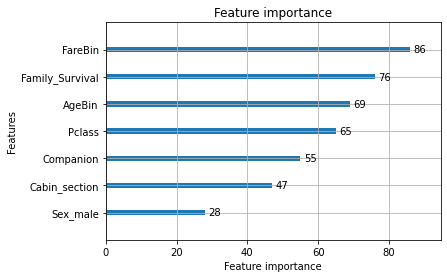

Fitting model 1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.151685	valid_1's binary_error: 0.176471
Did not meet early stopping. Best iteration is:
[53]	training's binary_error: 0.144195	valid_1's binary_error: 0.176471


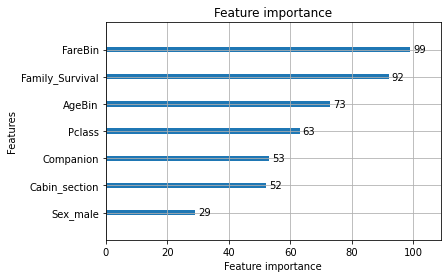

Fitting model 2
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.131086	valid_1's binary_error: 0.156863
Did not meet early stopping. Best iteration is:
[50]	training's binary_error: 0.131086	valid_1's binary_error: 0.156863


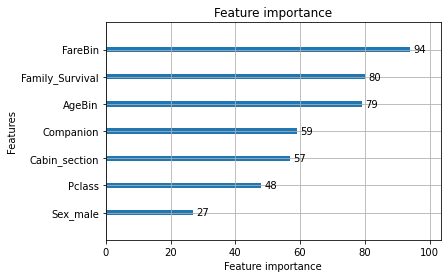

Fitting model 3
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.155431	valid_1's binary_error: 0.165266
Did not meet early stopping. Best iteration is:
[49]	training's binary_error: 0.153558	valid_1's binary_error: 0.165266


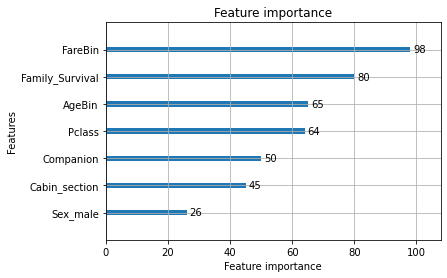

Fitting model 4
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.144195	valid_1's binary_error: 0.154062
Did not meet early stopping. Best iteration is:
[48]	training's binary_error: 0.136704	valid_1's binary_error: 0.159664


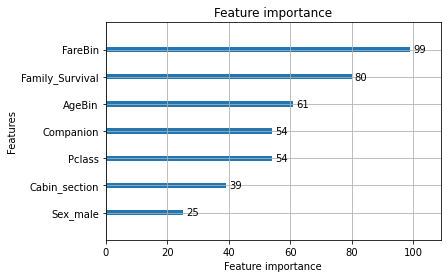

Fitting model 5
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.155431	valid_1's binary_error: 0.165266
Did not meet early stopping. Best iteration is:
[55]	training's binary_error: 0.153558	valid_1's binary_error: 0.162465


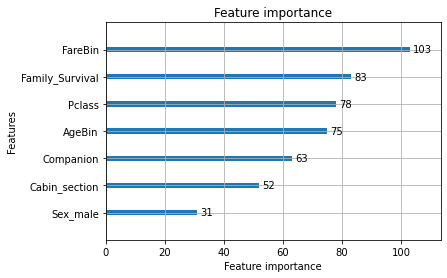

Fitting model 6
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.153558	valid_1's binary_error: 0.196078
Did not meet early stopping. Best iteration is:
[55]	training's binary_error: 0.142322	valid_1's binary_error: 0.173669


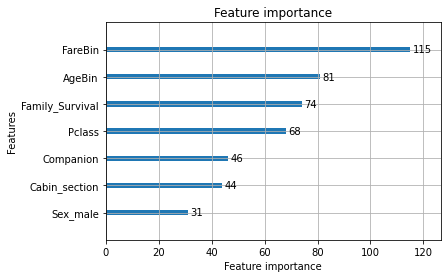

Fitting model 7
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.127341	valid_1's binary_error: 0.173669
Did not meet early stopping. Best iteration is:
[51]	training's binary_error: 0.125468	valid_1's binary_error: 0.179272


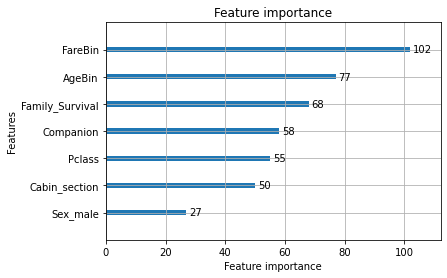

Fitting model 8
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.146067	valid_1's binary_error: 0.131653
Did not meet early stopping. Best iteration is:
[51]	training's binary_error: 0.142322	valid_1's binary_error: 0.134454


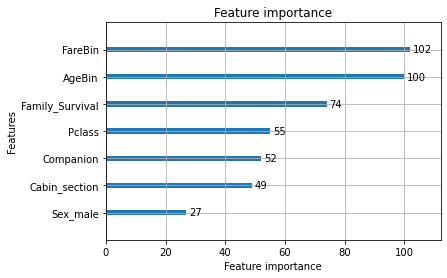

Fitting model 9
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.138577	valid_1's binary_error: 0.19888
Did not meet early stopping. Best iteration is:
[54]	training's binary_error: 0.131086	valid_1's binary_error: 0.184874


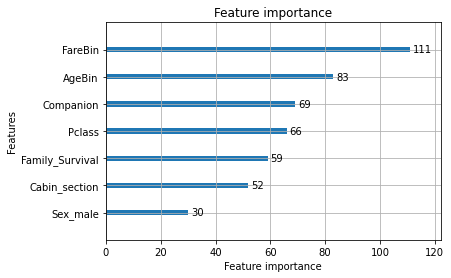

In [13]:
k = 10
valid_preds, train_preds, result = 0, 0, 0
for m in range(k):
    
    print('Fitting model', m)

        # Prepare the data set for fold
    train_split_df, valid_split_df = train_test_split(df_train, test_size=0.4)
    (train_lgb_dataset, train_labels,train_ids, train_split_df) = prepare_for_light_gbm(
            train_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
    (valid_lgb_dataset, valid_labels,valid_ids, valid_split_df) = prepare_for_light_gbm(
            valid_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
        # Train
    gbm = lgb.train(best_params, train_lgb_dataset, num_boost_round=100000,
                        valid_sets=[train_lgb_dataset, valid_lgb_dataset],
                        early_stopping_rounds=50, verbose_eval=50)

        # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

        # Predict
    valid_preds += gbm.predict(valid_split_df, 
                                num_iteration=gbm.best_iteration) / k
    train_preds += gbm.predict(train_split_df, 
                                num_iteration=gbm.best_iteration) / k
    result += gbm.predict(df_test, num_iteration=gbm.best_iteration) / k 

In [14]:
result_write = np.int32(result > 0.5)
temp=pd.read_csv('../input/titanic/test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result_write}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('submission_opt7.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../input/titanic/test.csv'